# Recognizer Facial 

In this project,  construct face recognizer based on features extracted from the neural network. The project consists of two parts: image classification and video classification. In the first one : Classify distinct images and in the second: Deal with short video sequences.

In [0]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

In [0]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2, csv
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['resize', 'copy', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Reading data for image and video classification  

Function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [0]:
import os
from os.path import join
import pandas as pd
from skimage.io import imread

In [0]:
def load_image_data(dir_name = '/content/Face_Recognition_data/image_classification'):
    x_train, y_train, x_test, y_test = {}, {}, {}, {}
    for filename in os.listdir(join(dir_name, 'train', 'images')):
        img = imread(join(dir_name, 'train', 'images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_train[filename] = img
    data_train = pd.read_csv(join(dir_name, 'train', 'y_train.csv'))
    for filename, ix in zip(data_train['filename'], data_train['ix']):
        y_train[filename] = ix
        
    for filename in os.listdir(join(dir_name, 'test', 'images')):
        img = imread(join(dir_name, 'test', 'images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_test[filename] = img
    data_test = pd.read_csv(join(dir_name, 'test', 'y_test.csv'))
    for filename, iy in zip(data_test['filename'], data_test['iy']):
        y_test[filename] = iy
    return x_train, y_train, x_test, y_test
    pass

In [0]:
x_train, y_train, x_test, y_test = load_image_data()
print '%d'%len(x_train), '\ttraining images'
print '%d'%len(x_test), '\ttesting images'

661 	training images
808 	testing images


In [0]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(data.keys(), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

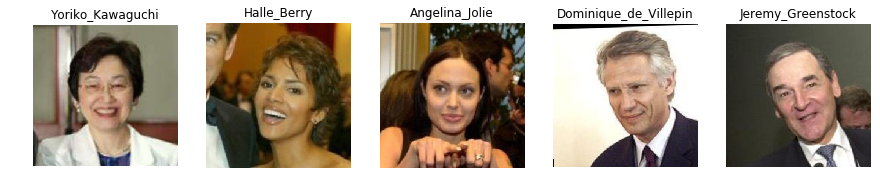

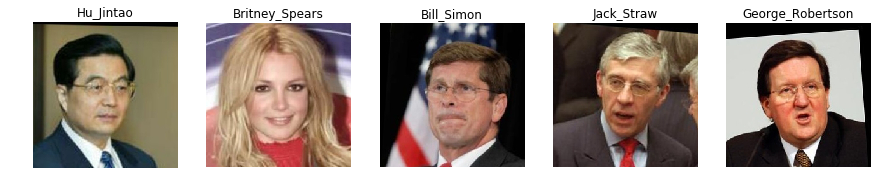

In [0]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [0]:
import matplotlib.image as mpimg

def load_video_data(dir_name = '/content/Face_Recognition_data/video_classification'):
    train_labels, train_images= {}, {}
    with open(os.path.join(dir_name,"train/y_train.csv"), 'r') as csvfile:
        folder = "./train/images"
        csvreader = csv.reader(csvfile)
        k=0
        for i in csvreader:
            if k==0:
                k+=1
                continue
            filename = i[0]
            train_labels[filename] = i[1]
            train_images[filename] =  mpimg.imread(os.path.join(dir_name,folder,filename))
    
    test_labels, test_images = {},{}
    with open(os.path.join(dir_name,"test/y_test.csv"), 'r') as csvfile:
        folder = "test/videos"
        csvreader = csv.reader(csvfile)
        k=0
        for i in csvreader:
            k+=1
            if k==1:
                continue
            if k==11:
                break
            foldername = i[0]
            test_labels[foldername] = i[1]
            test_images[foldername] = []
            for filename in os.listdir(os.path.join(dir_name,folder,foldername)):
                test_images[foldername].append(mpimg.imread(os.path.join(dir_name,folder,foldername,filename)))
    
    return train_images,train_labels,test_images,test_labels

In [0]:
video_train, train_labels, video_test, test_labels = load_video_data()
print '%d'%len(video_train), '\ttraining images'
print '%d'%len(video_test), '\ttesting videos'

729 	training images
9 	testing videos


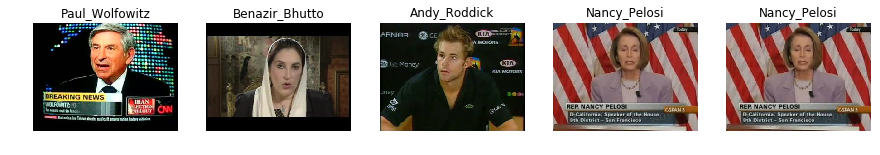

In [0]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing 
I will implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. 

In [0]:
import dlib
from cv2 import resize
detector = dlib.get_frontal_face_detector()
def preprocess_imgs(imgs):
    sc = []   
    for img in imgs:
        detc = detector(img)
        if len(detc) == 0:
            cropped = resize(img, (224, 224))
            sc.append(cropped)
            continue
        for d in detc:
            scale = 0.2
            top = d.top()
            bottom = d.bottom()
            left = d.left()
            right = d.right()
            height = bottom - top
            width = right - left
            top = max(0, int(top - height*scale))
            bottom = min(img.shape[0], int(bottom + height*scale))
            left = max(0, int(left - width*scale))
            right = min(img.shape[1], int(right + width*scale))
            if top >= 0 and left >= 0:
                cropped = img[top:bottom, left:right, :]
                cropped = cv2.resize(cropped, (224, 224))
                sc.append(cropped)
                break
    if len(sc) == 0:
        imshow(imgs[0])
    return sc

#### Visualization of preprocessing

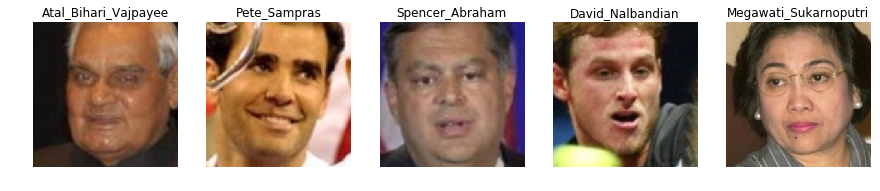

In [0]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

In [0]:
!pip install h5py

In [0]:
import h5py
from keras.models import load_model
# load model
model = load_model('/content/face_recognition_model.h5')
# summarize model.
model.summary()

W0317 02:24:16.365974 140694856095616 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0317 02:24:16.378493 140694856095616 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0317 02:24:16.387173 140694856095616 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0317 02:24:16.424287 140694856095616 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0317 02:24:16.856920 140694856095616 module_wrapper.py:139] From /usr/loca

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3).

In [0]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [0]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print out.shape

(1, 4096)


### Training classifier  



In [0]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
class Classifier():
    def __init__(self, nn_model, layer='fc7'):
        network_output = nn_model.get_layer(layer).output
        self.feature_extraction_model = Model(nn_model.input, network_output)
        self.clf = kNN(n_neighbors=2, weights='distance')
        pass


    def fit(self, train_imgs, train_labels):
        train_X = []
        train_y = []
        for k, v in train_imgs.items():
            pre_img = preprocess_imgs([v])[0]
            pre_img = pre_img[np.newaxis, ...]
            train_X_features = self.feature_extraction_model.predict(pre_img)
            train_X.append(train_X_features)
            train_y.append(train_labels[k])
            
        train_X = np.asarray(train_X)
        train_X = np.reshape(train_X, (-1, 4096))
        train_y = np.asarray(train_y)
        self.clf.fit(train_X,train_y)
        pass


    def classify_images(self, test_imgs):
        res = {}
        for key, val in test_imgs.items():
            imga = preprocess_imgs([val])[0]
            pre_img = imga[np.newaxis, ...]
            test_imga = self.feature_extraction_model.predict(pre_img)
            y_pred = self.clf.predict(test_imga)[0]
            res[key] = y_pred
       
        return res
        pass

       
        
    def classify_videos(self, test_video):
        res = {}
        for k, v in test_video.items():
            c = Counter()
            for img in v:
                imga = preprocess_imgs([img])[0]
                pre_img = pre_img[np.newaxis, ...]
                test_imga = self.feature_extraction_model.predict(pre_img)
                y_pred = self.clf.predict(test_imga)[0]
                table[y_pred] += 1
            res[k] = max(c, key=lambda x:table[x])

        return res
        pass

In [0]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

### Image classification quality  

 

In [0]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [0]:
print check_test(y_out, y_test)

Classification accuracy is 0.9554


### Video classification quality  

In [0]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test)

In [0]:
print check_test(y_video_out, test_labels)

Classification accuracy is 0.7778
